In [9]:
%pylab inline
import pandas as pd
import seaborn as sns
import scipy
import skimage
# sns.set_style("ticks")
from pathlib import Path
output_path_images = Path("../text/")
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0, str(path_to_script))
import scaffan
import scaffan.texture
import scaffan.slide_segmentation
import io3d # just to get data
import scaffan.image as scim
import io3d
import os
scaffan.__path__

Populating the interactive namespace from numpy and matplotlib


['C:\\Users\\Jirik\\projects\\scaffan\\scaffan']

# Read the data

2020-09-04 16:48:10.170 | WARNING  | io3d.datasets:join_path:299 - Function deprecated use joinp instead.
2020-09-04 16:48:10.171 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-09-04 16:48:10.182 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_.
2020-09-04 16:48:10.187 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical
2020-09-04 16:48:10.191 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig
2020-09-04 16:48:10.198 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis
2020-09-04 16:48:10.204 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi
2020-09-04 16:48:10.207 | DEBUG    | io3d.datasets:dataset_path:464 - returning path=C:\Users\Jirik\data , new_pat

[0.007271901, 0.007271901]
filename: C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi


2020-09-04 16:48:14.110 | DEBUG    | scaffan.annotation:read_annotations_ndpa:239 - windows annotation output:b'\x1b2020-09-04 16:48:13.887\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b118\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\nC:\\Users\\Jirik\\projects\\scaffan\\scaffan\\annotation.py:99: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to \'.//ndpviewstate\'\r\n  viewstates = tree.findall("//ndpviewstate")\r\n'


[51]


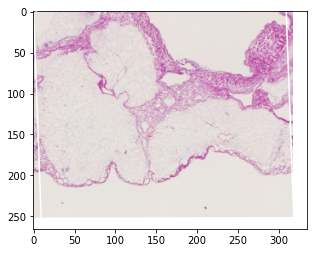

In [10]:
pixelsize_mm=[0.007271901] * 2
# pixelsize_mm=[0.00363595] * 2
# pixelsize_mm=[0.001817975] * 2
print(pixelsize_mm)

# fn = io3d.datasets.join_path("medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True)
fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True)
title = "full segmentation"

# f"{str(pixelsize_mm[0])}""
ofn_filled = output_path_images / f"ground_true_annotation_{Path(fn).stem}_{title}_pixelsize_mm_{pixelsize_mm[0]}.png"
ofn_raster = output_path_images / f"raster_{Path(fn).stem}_{title}_pixelsize_mm_{pixelsize_mm[0]}.png"


print(f"filename: {fn}")
anim = scim.AnnotatedImage(fn)

# ann_ids = anim.select_annotations_by_color("#000000")
ann_ids = anim.select_annotations_by_title(title)
print(ann_ids)
view = anim.get_views(
    ann_ids, 
#     level=6, 
    margin=0, pixelsize_mm=pixelsize_mm)[0]

img = view.get_region_image(as_gray=False)
plt.imsave(ofn_raster, img)

plt.imshow(img, cmap='gray')
view.plot_annotations(ann_ids[0])

# Get manual segmentations

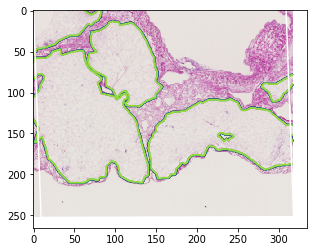

In [21]:

seg_black = view.get_annotation_raster_by_color("#000000")
seg_magenta = view.get_annotation_raster_by_color("#FF00FF")
seg_red = view.get_annotation_raster_by_color("#FF0000")

plt.imshow(img)
plt.contour(seg_black)
view.plot_annotations(ann_ids[0])


# Remove overlays

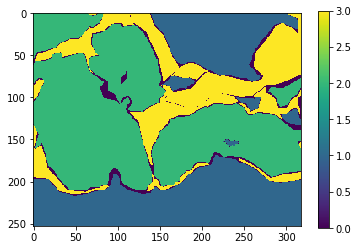

In [22]:
# see overlays
# plt.imshow(img)
overlays = (1*seg_black + 1*seg_magenta + 1* seg_red) > 1
segmentation = 2*seg_black + 1*seg_magenta + 3* seg_red
segmentation[overlays] = 0
plt.imshow(segmentation)
plt.colorbar()
# view.plot_annotations(ann_ids[0])

In [6]:
from scipy.ndimage import morphology
dst, inds = morphology.distance_transform_edt(segmentation==0, return_indices=True)
plt.imshow(dst)

NameError: name 'segmentation' is not defined

# Fill the gaps

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


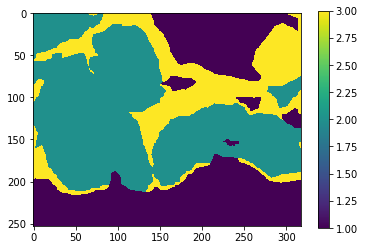

In [24]:
# plt.imshow(segmentation[inds[0], inds[1]])
filled = segmentation[[*inds]]
plt.imshow(filled, vmin=1)
plt.colorbar()

In [25]:
plt.imsave(ofn_filled, filled, 
#            cmap='gray', 
           vmin=0) # , "fn.png")

In [26]:
Path(fn).stem

'PIG-003_J-18-0165_HE'

In [27]:
# ann_raster = view.get_annotation_region_raster(outer_ids[0], holes_ids=hole_ids)

# Whole dataset preparation


Get training labels from whole dataset

In [11]:
output_path_images = Path(io3d.datasets.join_path(
    "medical/processed/scaffan2019/whole_scan_ground_true_training_annotations", get_root=True
))
fns = [
    "medical/orig/Scaffan-analysis/PIG-001_J-17-0571_LM central_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-001_J-17-0569_LM_HE.ndpi",
    # "medical/orig/Scaffan-analysis/PIG-001_J-17-0567_edge RM_HE.ndpi",  # no annotation
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0091_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0092_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0094_HE_rescan.ndpi", # bad focus
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0166_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0167_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0168_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0169_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0170_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-4_HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-3 _HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-2 _HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0630_HE_LLL per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0631_HE_LML per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0633_HE_PRML per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-008_P008 LL-C_HE_parenchyme centr..ndpi",
    "medical/orig/Scaffan-analysis/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi",
    #
    # "medical/orig/Scaffan-analysis-hů/PIG-001_J-17-0571_LM central_HE.ndpi", # Test diacritics
    #
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-014_Pilsen_HE_LM-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-013_Pilsen_HE_013-LL-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pilsen_Pig-015_HE_RLP_7.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pilsen_Pig-015_HE_RMP_4.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-014_Pilsen_HE_RL-C.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-010_Pilsen_HE_RM-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-013_Pilsen_HE_013-LL-C (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-009_Pilsen_HE_009-LM-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-010_Pilsen_HE_LL-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-011_Pilsen_HE_LL-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-009_Pilsen_HE_009-RL-C (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/PIG-012_Pilsen_HE_LLP (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-011_Pilsen_HE_RM-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/PIG-012_Pilsen_HE_LMC (1).ndpi',
]


2020-09-04 16:48:49.679 | WARNING  | io3d.datasets:join_path:299 - Function deprecated use joinp instead.
2020-09-04 16:48:49.680 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-09-04 16:48:49.687 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_.
2020-09-04 16:48:49.696 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical
2020-09-04 16:48:49.700 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/processed
2020-09-04 16:48:49.704 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/processed/scaffan2019
2020-09-04 16:48:49.711 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/processed/scaffan2019/whole_scan_ground_true_training_annotations
2020-09-04 16:48:49.718 | DEBUG    | io3d.datasets:dataset_path:464 - returning path=C:\Use

2020-09-04 16:53:19.691 | WARNING  | io3d.datasets:join_path:299 - Function deprecated use joinp instead.
2020-09-04 16:53:19.694 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-09-04 16:53:19.700 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_.
2020-09-04 16:53:19.708 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical
2020-09-04 16:53:19.712 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig
2020-09-04 16:53:19.716 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis
2020-09-04 16:53:19.720 | DEBUG    | io3d.datasets:dataset_path:442 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis/PIG-001_J-17-0571_LM central_HE.ndpi
2020-09-04 16:53:19.730 | DEBUG    | io3d.datasets:dataset_path:464 - returning path=C:\Users\Jirik\dat

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0571_LM central_HE.ndpi exists=True 


2020-09-04 16:53:23.563 | DEBUG    | scaffan.annotation:read_annotations_ndpa:239 - windows annotation output:b'\x1b2020-09-04 16:53:23.328\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b118\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\nC:\\Users\\Jirik\\projects\\scaffan\\scaffan\\annotation.py:99: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to \'.//ndpviewstate\'\r\n  viewstates = tree.findall("//ndpviewstate")\r\n'
2020-09-04 16:53:23.596 | DEBUG    | scaffan.slide_segmentation:_find_best_level:379 - wanted pixelsize mm=[0.01 0.01]
2020-09-04 16:53:23.602 | DEBUG    | scaffan.slide_segmentation:_find_best_level:395 - real pixelsize mm=[0.0072719 0.0072805]
2020-09-04 16:53:23.611 | DEBUG    | scaffan.slide_segmentation:make_tiles:453 - level=5, tile size on level=[256 256], tile size on level 0=[8

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0569_LM_HE.ndpi exists=True 


2020-09-04 16:59:26.207 | DEBUG    | scaffan.annotation:read_annotations_ndpa:239 - windows annotation output:b'\x1b2020-09-04 16:59:25.868\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b118\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\nC:\\Users\\Jirik\\projects\\scaffan\\scaffan\\annotation.py:99: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to \'.//ndpviewstate\'\r\n  viewstates = tree.findall("//ndpviewstate")\r\n'
2020-09-04 16:59:26.253 | DEBUG    | scaffan.slide_segmentation:_find_best_level:379 - wanted pixelsize mm=[0.01 0.01]
2020-09-04 16:59:26.258 | DEBUG    | scaffan.slide_segmentation:_find_best_level:395 - real pixelsize mm=[0.0072719 0.0072805]
2020-09-04 16:59:26.267 | DEBUG    | scaffan.slide_segmentation:make_tiles:453 - level=5, tile size on level=[256 256], tile size on level 0=[8

KeyboardInterrupt: 

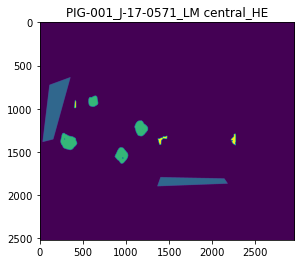

In [12]:

#     fn = io3d.datasets.join_path(
#         "medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True
#     )
pixelsizes = [ 
    0.005
    0.007271901, 0.00363595, 0.001817975
             ]

# if not os.path.exists(filename):
os.makedirs(output_path_images, exist_ok=True)

for pixelsize0 in pixelsizes:
    pixelsize_mm = [pixelsize0, pixelsize0]
    for fn_in_datasets in fns: 
        fn = io3d.datasets.join_path(fn_in_datasets, get_root=True)
        print(f"{fn} exists={Path(fn).exists()} ")
        
        ofn_gt = output_path_images / f"training_annotation_{Path(fn).stem}_pixelsize_mm_{pixelsize_mm[0]}.png"
        ofn_raster = output_path_images / f"raster_{Path(fn).stem}_pixelsize_mm_{pixelsize_mm[0]}.png"
#         print(fn = Path(fn).stem)
    #     report = exsu.Report(outputdir="./experiment_whole_slide_ground_true/slide_seg_test_output/")
        report = None
        seg = scaffan.slide_segmentation.ScanSegmentation(report=report)
        # dir(seg)
        anim = scaffan.image.AnnotatedImage(fn)

        seg.init(anim.get_full_view())
        seg.parameters.param("Segmentation Method").setValue("U-Net")
        seg.parameters.param("Save Training Labels").setValue(True)
        seg.parameters.param("Working Resolution").setValue(pixelsize0 * 0.001)
    #     ann_ids_black = seg.anim.select_annotations_by_color("#000000")
    #     assert 10 in ann_ids_black
    #     assert 11 in ann_ids_black
        seg.run()
    #     assert type(seg.full_output_image) == np.ndarray
    #     assert type(seg.full_raster_image) == np.ndarray
    #     assert type(seg.whole_slide_training_labels) == np.ndarray
    #     assert seg.full_raster_image.shape[:2] == seg.full_output_image.shape[:2]
    #     assert seg.whole_slide_training_labels.shape[:2] == seg.full_output_image.shape[:2]
        plt.imsave(ofn_gt, seg.whole_slide_training_labels)
        plt.imsave(ofn_raster, seg.full_raster_image.astype(np.uint8))
        plt.figure()
        plt.title(str(Path(fn).stem))
        plt.imshow(seg.whole_slide_training_labels)